# **Stochastic Gradient Descent From Scratch in Python**
*By Cristian Leo*

*Link Article*: https://medium.com/@cristianleo120/stochastic-gradient-descent-math-and-python-code-35b5e66d6f79

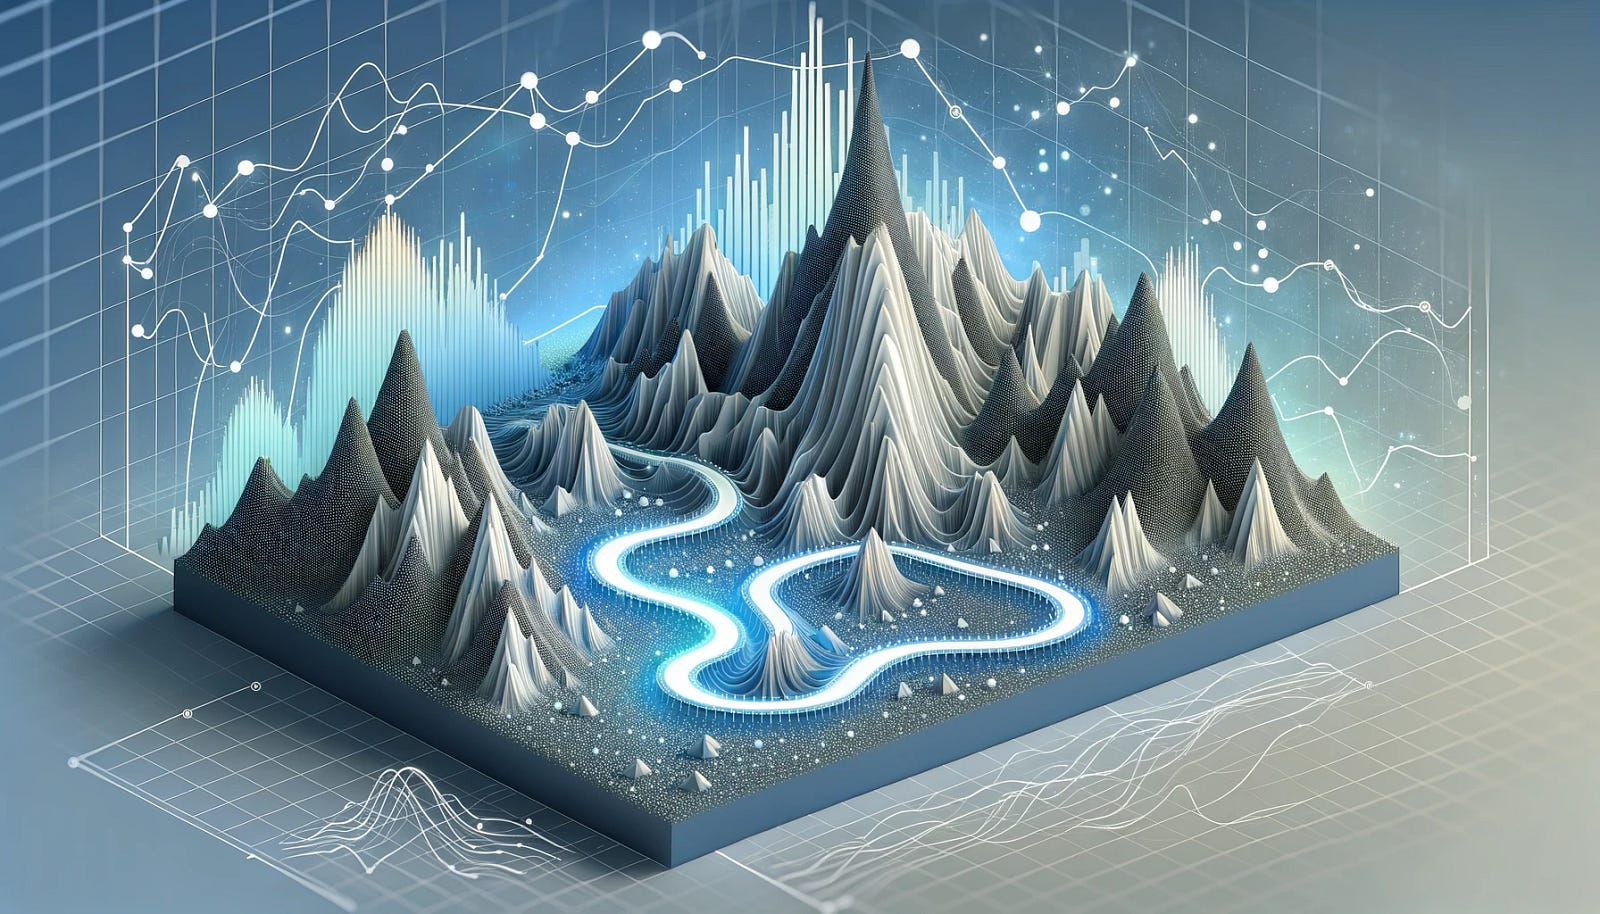
Author: **Cristian Leo**
## **Import Required Libraries**

In [6]:
# Basic Libraries
import numpy as np
import pandas as pd

# Load Data
from sklearn.datasets import load_diabetes

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model Fine Tuning
import optuna

# Filter Warnings
import warnings
warnings.filterwarnings('ignore')

## **SGD Regressor Class**

In [7]:
class SGDRegressor:
    def __init__(self, learning_rate=0.01, epochs=100, batch_size=1, reg=None, reg_param=0.0):
        """
        Constructor for the SGDRegressor.

        Parameters:
        learning_rate (float): The step size used in each update.
        epochs (int): Number of passes over the training dataset.
        batch_size (int): Number of samples to be used in each batch.
        reg (str): Type of regularization ('l1' or 'l2'); None if no regularization.
        reg_param (float): Regularization parameter.

        The weights and bias are initialized as None and will be set during the fit method.
        """
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.reg = reg
        self.reg_param = reg_param
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        """
        Fits the SGDRegressor to the training data.

        Parameters:
        X (numpy.ndarray): Training data, shape (m_samples, n_features).
        y (numpy.ndarray): Target values, shape (m_samples,).

        This method initializes the weights and bias, and then updates them over a number of epochs.
        """
        m, n = X.shape  # m is number of samples, n is number of features
        self.weights = np.zeros(n)
        self.bias = 0

        for _ in range(self.epochs):
            indices = np.random.permutation(m)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            for i in range(0, m, self.batch_size):
                X_batch = X_shuffled[i:i+self.batch_size]
                y_batch = y_shuffled[i:i+self.batch_size]

                gradient_w = -2 * np.dot(X_batch.T, (y_batch - np.dot(X_batch, self.weights) - self.bias)) / self.batch_size
                gradient_b = -2 * np.sum(y_batch - np.dot(X_batch, self.weights) - self.bias) / self.batch_size

                if self.reg == 'l1':
                    gradient_w += self.reg_param * np.sign(self.weights)
                elif self.reg == 'l2':
                    gradient_w += self.reg_param * self.weights

                self.weights -= self.learning_rate * gradient_w
                self.bias -= self.learning_rate * gradient_b

    def predict(self, X):
        """
        Predicts the target values using the linear model.

        Parameters:
        X (numpy.ndarray): Data for which to predict target values.

        Returns:
        numpy.ndarray: Predicted target values.
        """
        return np.dot(X, self.weights) + self.bias

    def compute_loss(self, X, y):
        """
        Computes the loss of the model.

        Parameters:
        X (numpy.ndarray): The input data.
        y (numpy.ndarray): The true target values.

        Returns:
        float: The computed loss value.
        """
        return (np.mean((y - self.predict(X)) ** 2) + self._get_regularization_loss()) ** 0.5

    def _get_regularization_loss(self):
        """
        Computes the regularization loss based on the regularization type.

        Returns:
        float: The regularization loss.
        """
        if self.reg == 'l1':
            return self.reg_param * np.sum(np.abs(self.weights))
        elif self.reg == 'l2':
            return self.reg_param * np.sum(self.weights ** 2)
        else:
            return 0

    def get_weights(self):
        """
        Returns the weights of the model.

        Returns:
        numpy.ndarray: The weights of the linear model.
        """
        return self.weights

## **Load Diabetes Data**

In [8]:
# Load the diabetes dataset
diabetes = load_diabetes()
df = pd.DataFrame(data=diabetes.data, columns=diabetes.feature_names)
df['target'] = diabetes.target
df.head()

age       sex       bmi        bp        s1        s2        s3  \
0  0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
1 -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2  0.085299  0.050680  0.044451 -0.005670 -0.045599 -0.034194 -0.032356   
3 -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
4  0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   

         s4        s5        s6  target  
0 -0.002592  0.019907 -0.017646   151.0  
1 -0.039493 -0.068332 -0.092204    75.0  
2 -0.002592  0.002861 -0.025930   141.0  
3  0.034309  0.022688 -0.009362   206.0  
4 -0.002592 -0.031988 -0.046641   135.0

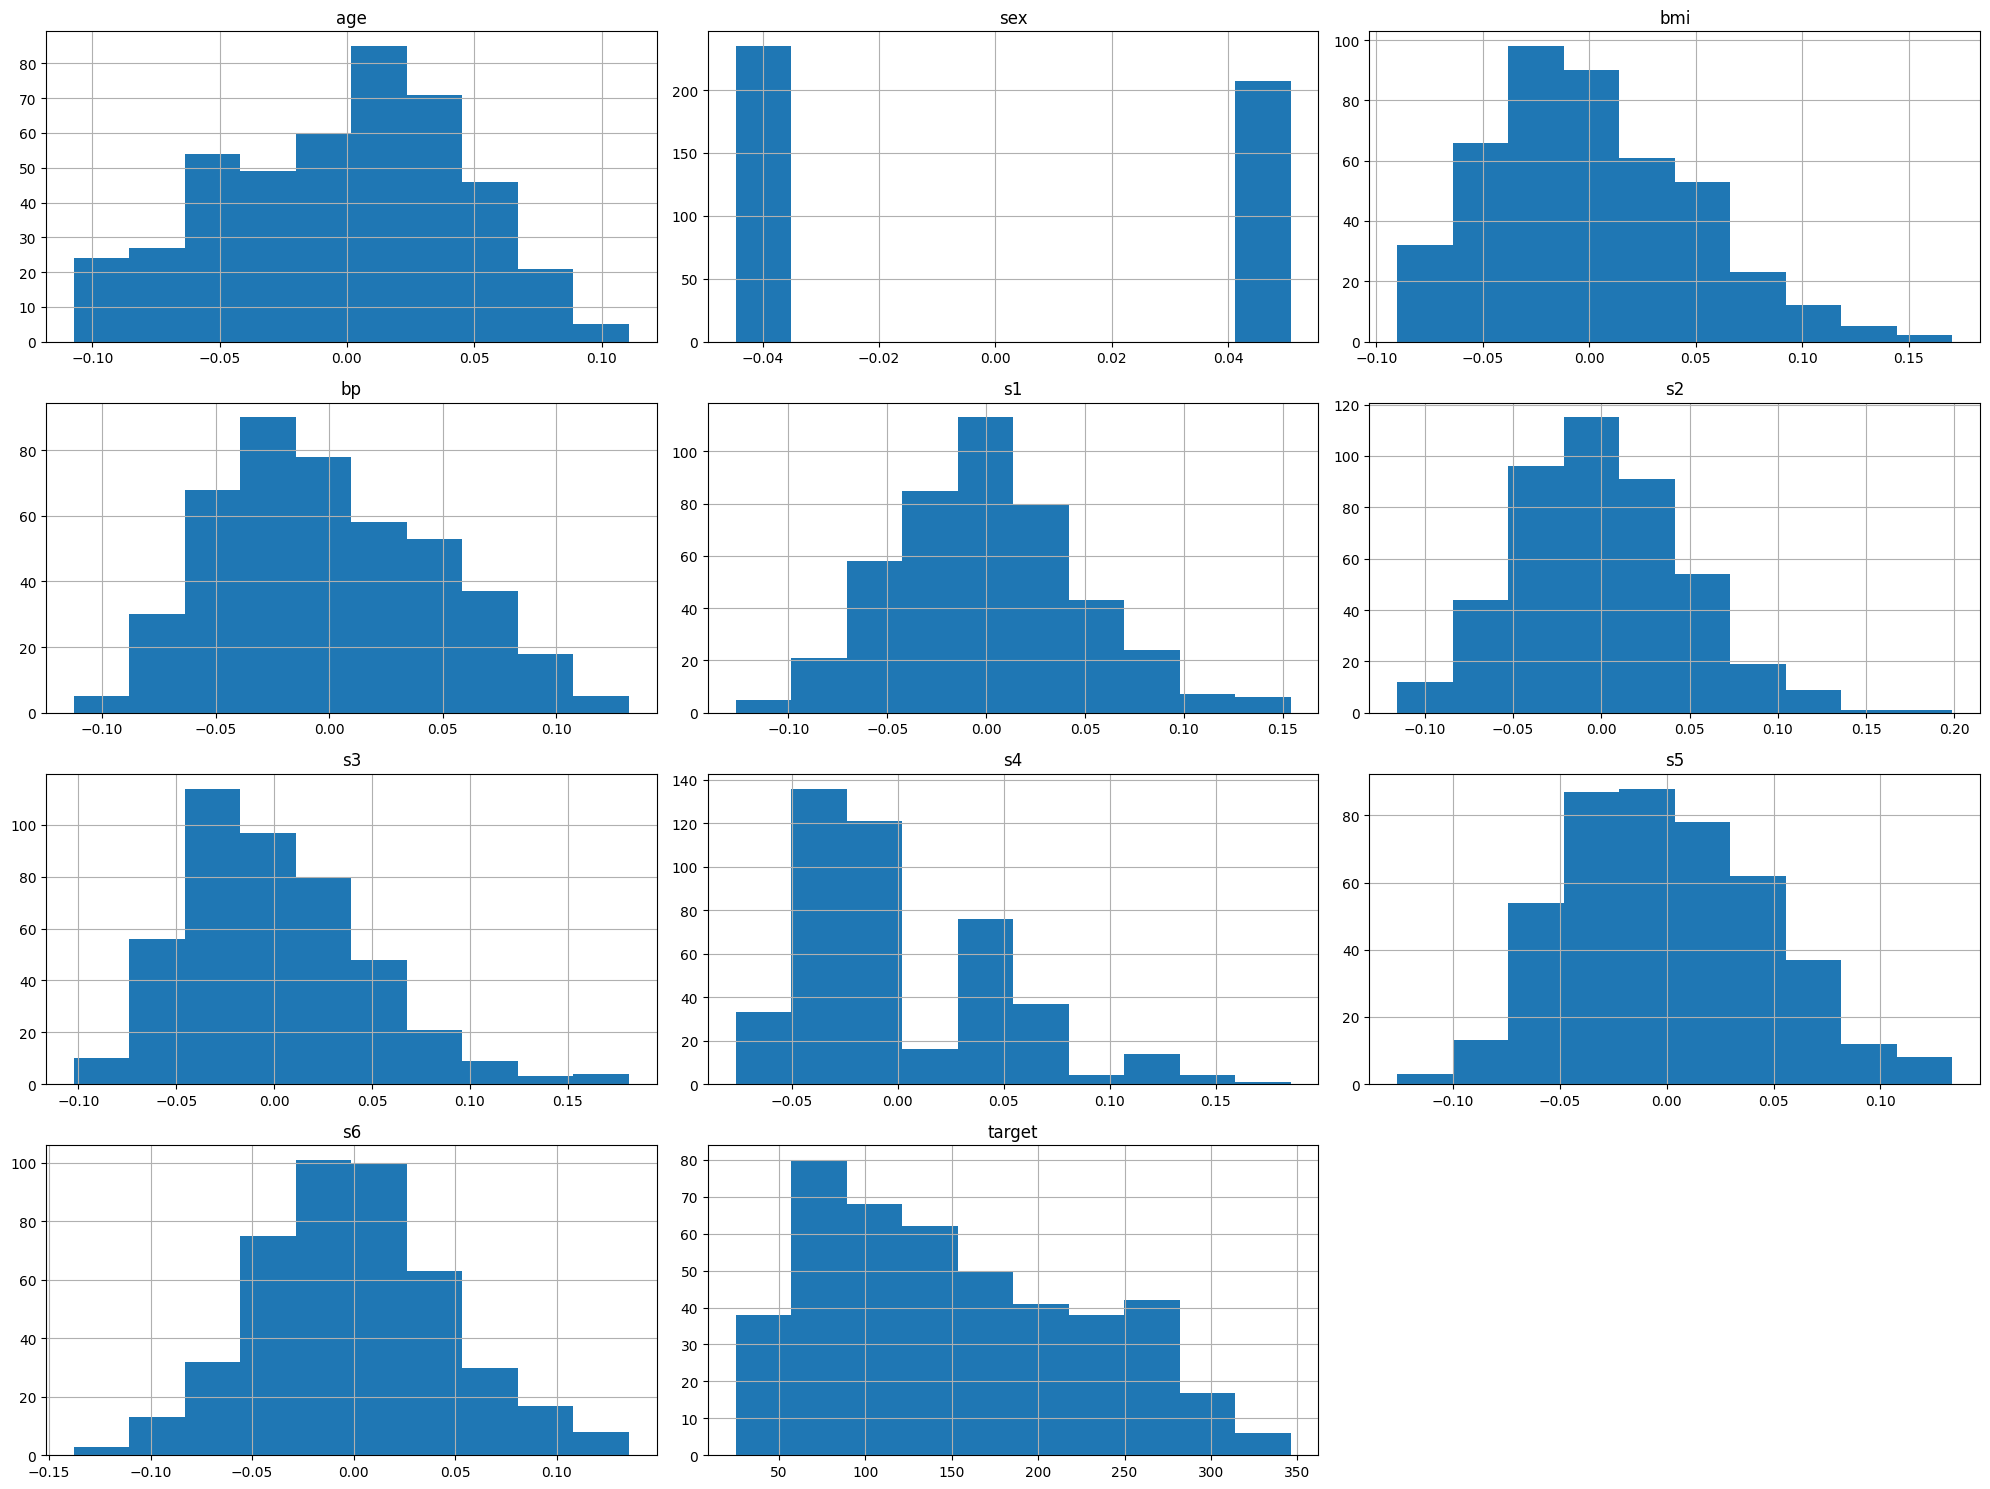

In [9]:
# Create histograms for each feature
df.hist(bins=10, figsize=(20, 15))
plt.tight_layout()
plt.show()

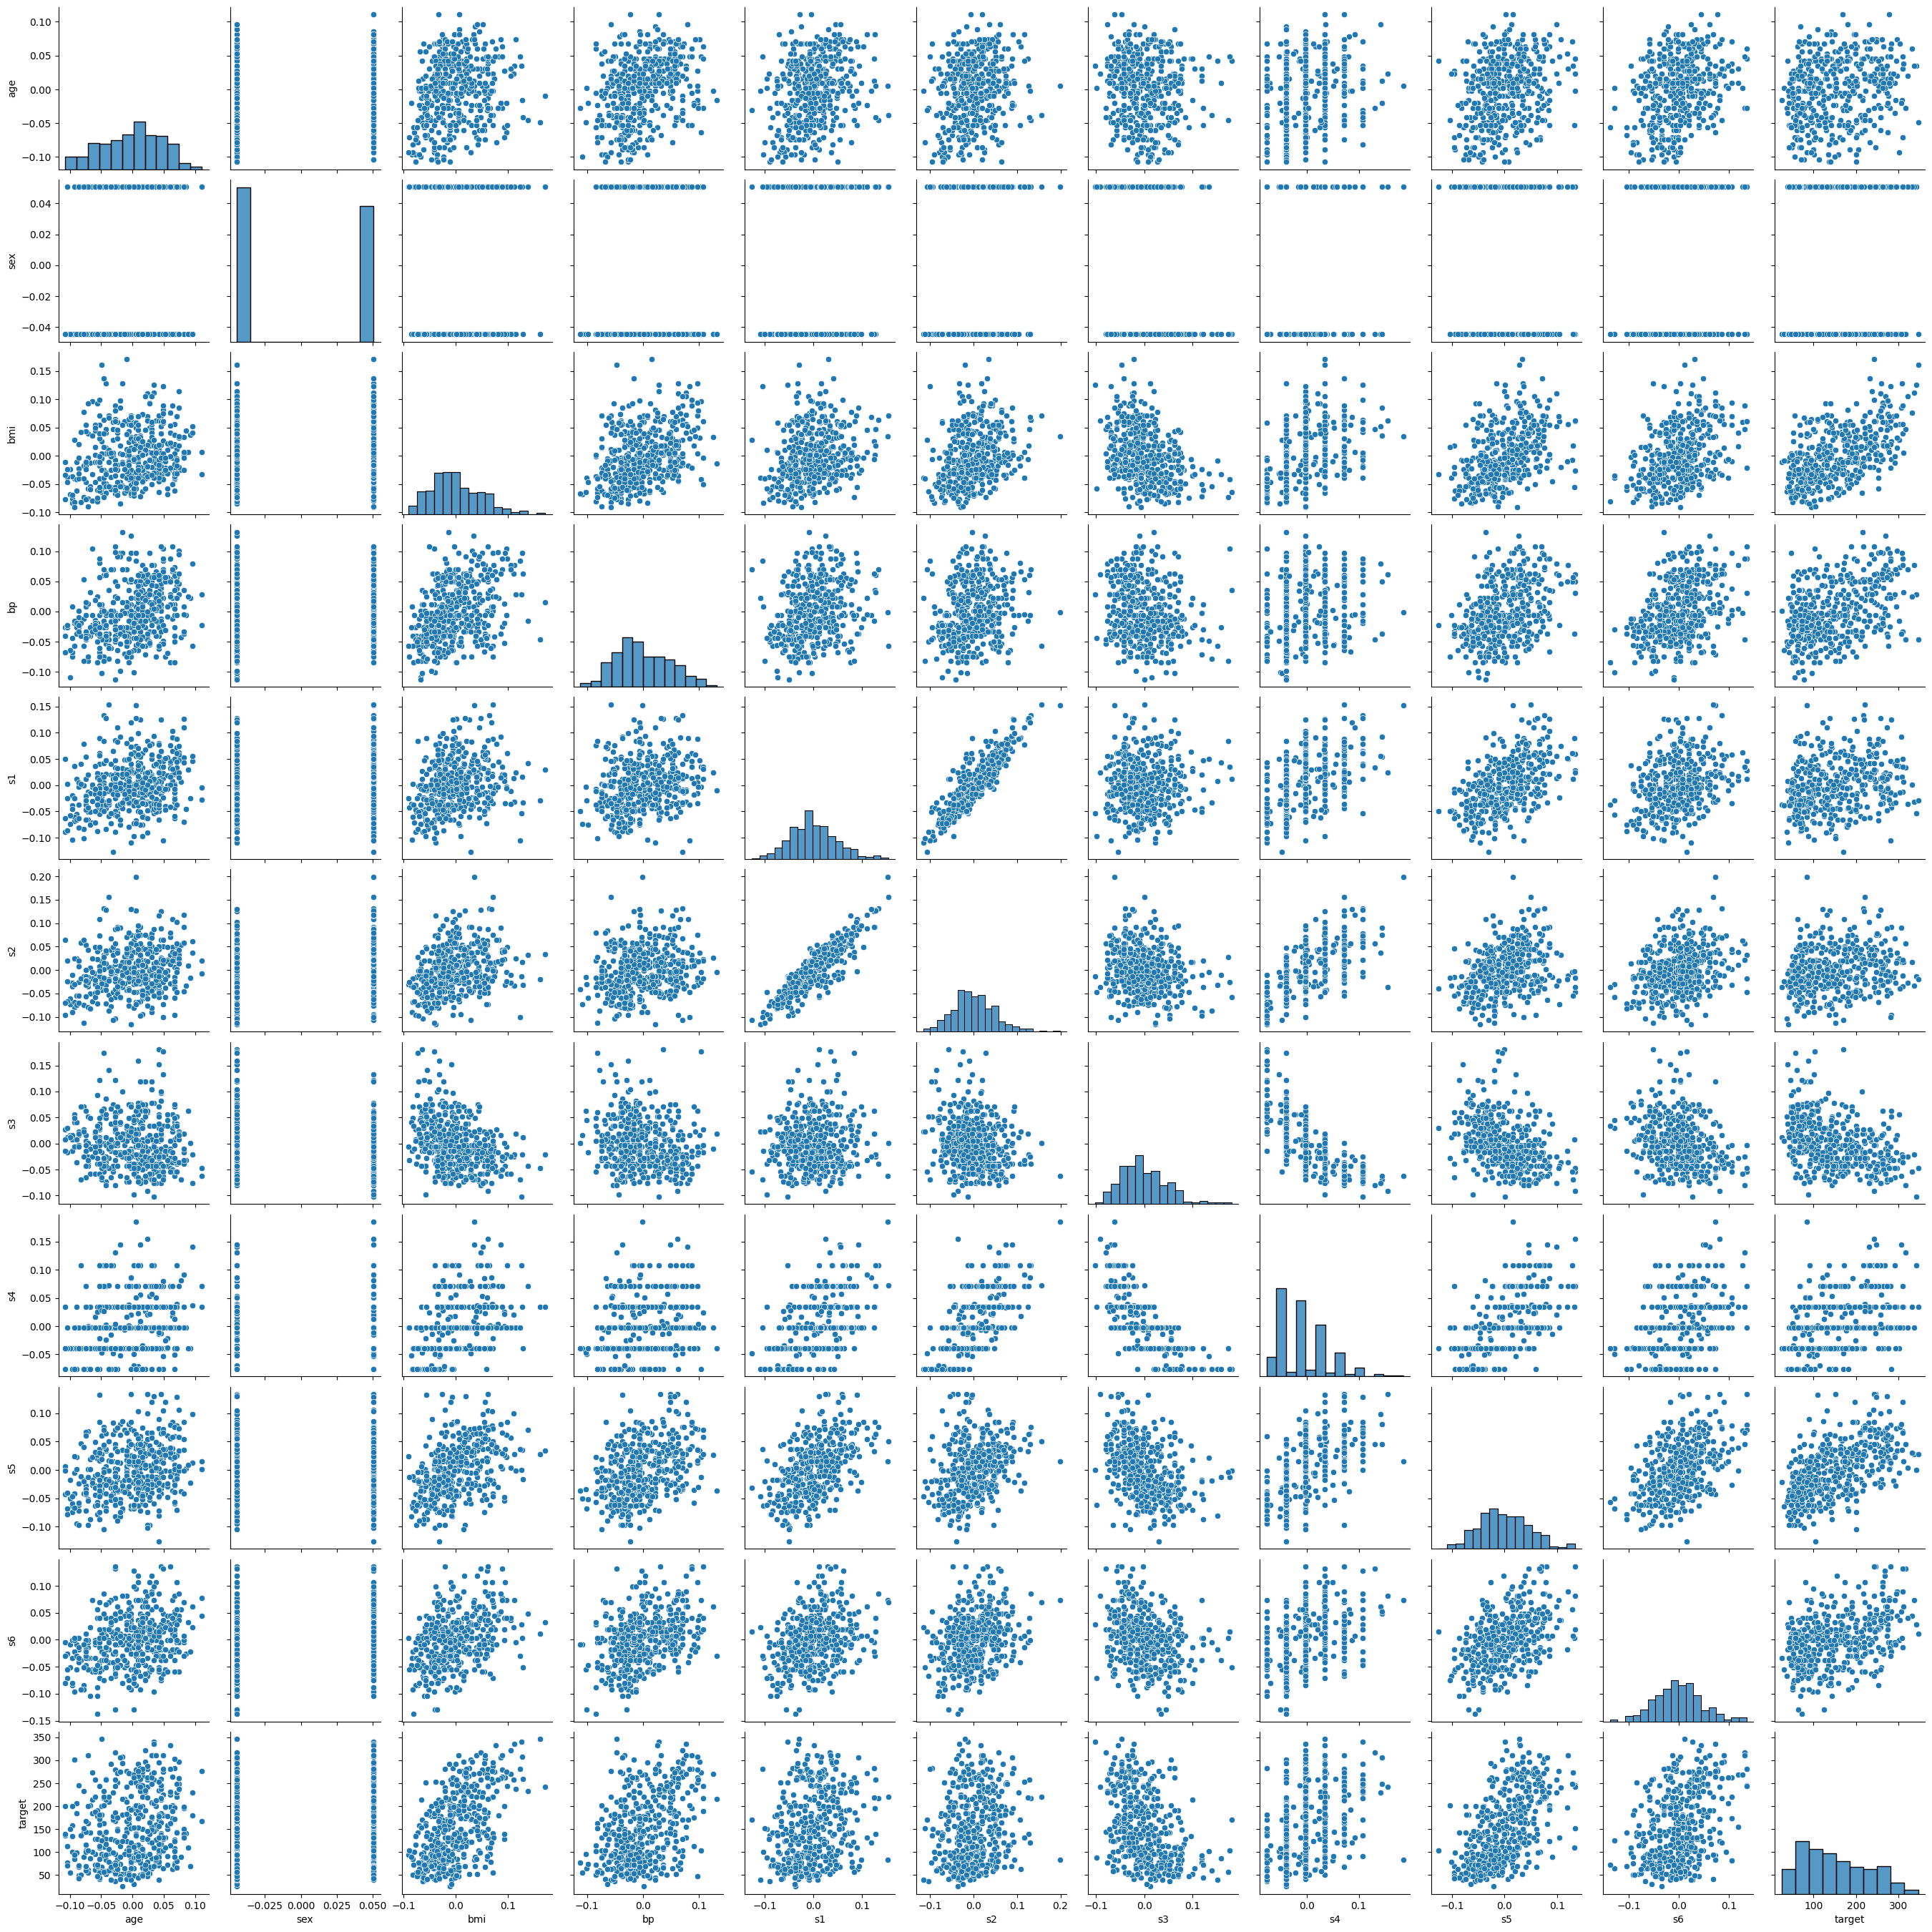

In [10]:
# Pairplot of the features
sns.pairplot(df)

## **Split Data**

In [11]:
# Get the input features (X) and target values (y)
X = diabetes.data
y = diabetes.target

# Split the dataset into training and test sets
def split_dataset(X, y, test_ratio=0.2):
    indices = np.random.permutation(len(X))
    test_size = int(len(X) * test_ratio)
    test_indices = indices[:test_size]
    train_indices = indices[test_size:]
    return X[train_indices], X[test_indices], y[train_indices], y[test_indices]

X_train, X_test, y_train, y_test = split_dataset(X, y)
X_train, X_val, y_train, y_val = split_dataset(X_train, y_train)

## **Fine-Tune Model with Optuna**

In [12]:
def objective(trial):
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 1e-1)
    epochs = trial.suggest_int('epochs', 30, 250)
    batch_size = trial.suggest_categorical('batch_size', [1, 10, 50, 100])
    reg_param = trial.suggest_loguniform('reg_param', 1e-5, 1e-1)
    reg = trial.suggest_categorical('reg', ['l1', 'l2'])

    regressor = SGDRegressor(learning_rate=learning_rate, epochs=epochs, batch_size=batch_size, reg=reg, reg_param=reg_param)
    regressor.fit(X_train, y_train)

    # Compute the validation loss
    val_loss = regressor.compute_loss(X_val, y_val)

    return val_loss

optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

best_params = study.best_params

In [13]:
for key, value in best_params.items():
    if key == 'reg':
        print(f'{key.capitalize()}: {value.capitalize()}')
    else:
        print(f'{key.capitalize()}: {value:.3f}')

Learning_rate: 0.050
Epochs: 143.000
Batch_size: 1.000
Reg_param: 0.000
Reg: L1


## **Predict Data**

In [14]:
best_regressor = SGDRegressor(learning_rate=best_params['learning_rate'], epochs=best_params['epochs'], batch_size=best_params['batch_size'], reg='l1', reg_param=best_params['reg_param'])
best_regressor.fit(X_train, y_train)
predictions = best_regressor.predict(X_test)
loss = best_regressor.compute_loss(X_test, y_test)
print(f"Best model loss on test data: {loss:.2f}")

Best model loss on test data: 56.46
